## Imports ##

In [1]:
import sys
sys.path.insert(1, '../')

import os
import pickle
import json
import joblib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import mne
# from mne import events_from_annotations, concatenate_raws

from sklearn.model_selection import train_test_split
from scipy.interpolate import CubicSpline
from scipy.integrate import simps
from sklearn.metrics import r2_score
import scipy.io
from scipy.io import loadmat

from sklearn.metrics import classification_report, accuracy_score

from processing.Processing_EEG import process_eeg_raw, process_eeg_epochs
from processing.Processing_NIRS import process_nirs_raw, process_nirs_epochs

from utilities.Read_Data import read_subject_raw_nirs, read_subject_raw_eeg
from utilities.utilities import translate_channel_name_to_ch_id, find_sections, spatial_zscore

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import csv
from sklearn.metrics import r2_score

import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from iTransformer.iTransformer.iTransformerTranscoding import iTransformer

import gc

from config.Constants import *


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {DEVICE}')

Device: cpu


In [2]:
# create directorys if they dont exist
if not os.path.exists(MODEL_WEIGHTS):
    os.makedirs(MODEL_WEIGHTS)
if not os.path.exists(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)

## Parameters - Raw ##

In [3]:
## Subject/Trial Parameters ##
subject_ids = np.arange(1,27) # 1-27
subjects = []
for i in subject_ids:
    subjects.append(f'VP{i:03d}')

tasks = ['nback']

# NIRS Sampling rate
fnirs_sample_rate = 10
# EEG Downsampling rate
eeg_sample_rate = 10

# Do processing or not
do_processing = True

# Redo preprocessing pickle files, TAKES A LONG TIME 
redo_preprocessing = False

# Redo data formating pickle files, TAKES A LONG TIME
redo_data_formatting = False

## Signal Prediction ##

### Parameters - Signal Prediction

In [4]:
# Time window (seconds)
eeg_t_min = 0
eeg_t_max = 1
nirs_t_min = -10
nirs_t_max = 10

offset_t = 0

# Train/Test Size
train_size = 4000
test_size = 500

# training loop
num_epochs = 1000

do_load = False
do_train = False

# data projection
nirs_token_size = 10
eeg_token_size = 5
fnirs_lookback = 4000
eeg_lookback = 200

use_hbr = False

test_size_in_subject = 0.2 # percent of test data
redo_train = True

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_features, hidden_dim, output_steps):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_features, hidden_size=hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_steps)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        y_pred = self.linear(lstm_out)
        return y_pred

def create_rnn(n_input, n_output):
    '''
       n_input (360)
       n_output (150)
    '''
    print(f'Creating RNN with input size: {n_input} and output size: {n_output}')
    model = LSTMModel(n_input, 20, n_output)

    return model

def create_mlp(n_input, n_output):
    '''
       n_input (360)
       n_output (150)
    '''
    print(f'Creating MLP with input size: {n_input} and output size: {n_output}')
    model = nn.Sequential(
        nn.Linear(n_input, 256),
        nn.ReLU(),
        nn.Linear(256, n_output)
    )

    return model

def create_transformer(nirs_channels_to_use_base, eeg_channels_to_use):
    model = iTransformer(
            num_variates = len(nirs_channels_to_use_base),
            lookback_len = fnirs_lookback,      # or the lookback length in the paper
            target_num_variates=len(eeg_channels_to_use),
            target_lookback_len=eeg_lookback,
            dim = 256,                          # model dimensions
            depth = 6,                          # depth
            heads = 8,                          # attention heads
            dim_head = 64,                      # head dimension
            attn_dropout=0.1,
            ff_mult=4,
            ff_dropout=0.1,
            num_mem_tokens=10,
            num_tokens_per_variate = 1,         # experimental setting that projects each variate to more than one token. the idea is that the network can learn to divide up into time tokens for more granular attention across time. thanks to flash attention, you should be able to accommodate long sequence lengths just fine
            use_reversible_instance_norm = True # use reversible instance normalization, proposed here https://openreview.net/forum?id=cGDAkQo1C0p . may be redundant given the layernorms within iTransformer (and whatever else attention learns emergently on the first layer, prior to the first layernorm). if i come across some time, i'll gather up all the statistics across variates, project them, and condition the transformer a bit further. that makes more sense
        )
    
    return model

def predict_eeg(model, data_loader, n_samples, n_channels, n_lookback, eeg_token_size, eeg_fpcas):
    # Set model to evaluation mode
    model.eval()

    # Perform inference on test data
    predictions = []
    targets = []
    for batch_idx, (X_batch, y_batch) in enumerate(data_loader):
        X_batch = X_batch.to(DEVICE).float()
        y_batch = y_batch.to(DEVICE).float()
        predictions.append(model(X_batch).detach().cpu().numpy())
        targets.append(y_batch.detach().cpu().numpy())

    predictions = np.array(predictions)
    targets = np.array(targets)
    
    targets = targets.reshape((n_samples, n_lookback, n_channels))

    # inverse CA on predictions
    predictions = predictions.reshape(n_samples, eeg_token_size, n_channels)
    predictions = predictions.transpose(0,2,1)
    # predictions = predictions.reshape(eeg_windowed_test.shape[0], eeg_token_size, eeg_windowed_test.shape[2])
    predictions = inverse_transform_fpca_over_channels(predictions, eeg_fpcas, eeg_lookback)
    predictions = predictions.transpose(0,2,1)

    return targets, predictions

### CCA

In [6]:
import concurrent.futures
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA

def inverse_transform_cca_over_channels(data, cca_dict, window):
    '''Perform CCA over channels of the data
    input:
        data (samples x channels x tokens)
        cca_dict (dictionary over channels of fit cca object)
    output:
        data (samples x channels x window)
    '''
    n_samples, n_channels, _ = data.shape

    tokenized_data = np.zeros((n_samples, n_channels, window))
    for i in range(n_channels):
        cca = cca_dict[i]
        tokenized_data[:, i, :] = cca.inverse_transform(data[:, i, :])

    return tokenized_data

def perform_cca_over_channels(data, cca_dict, n_components):
    '''Perform CCA over channels of the data
    input:
        data (samples x channels x window)
        cca_dict (dictionary over channels of fit cca object)
    output:
        data (samples x channels x tokens)
    '''
    n_samples, n_channels, _ = data.shape
    tokenized_data = np.zeros((n_samples, n_channels, n_components))
    for i in range(n_channels):
        cca = cca_dict[i]
        tokenized_data[:, i, :] = cca.transform(data[:, i, :])

    return tokenized_data

def fit_cca_single_channel(data_reshaped_a, data_reshaped_b, n_components, channel_idx):
    cca = CCA(n_components=n_components)
    cca.fit(data_reshaped_b, data_reshaped_a)
    return channel_idx, cca

def fit_cca_model(time_series_a, time_series_b, n_components):
    '''Fit CCA model to the data
    input:
        time_series_a (samples x channels x window)
        time_series_b (samples x channels x window)
        n_components (int)
    output:
        cca_dict (dictionary over channels of fit cca object)
    '''
    n_samples, n_channels, _ = time_series_b.shape
    cca_dict = {}

    data_reshaped_a = time_series_a.reshape(n_samples, -1)
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(fit_cca_single_channel, data_reshaped_a, time_series_b[:, i, :], n_components, i)
            for i in range(n_channels)
        ]
        for future in concurrent.futures.as_completed(futures):
            channel_idx, cca = future.result()
            cca_dict[channel_idx] = cca
            if channel_idx % 10 == 0:
                print(f'Finished fitting CCA for channel {channel_idx + 1}')

    return cca_dict

def get_cca_dict(subject_id, train_nirs_data, train_eeg_data, token_size):
    cca_dict_path = os.path.join(MODEL_WEIGHTS, f'cca_dict_{subject_id}.pkl')
    if not os.path.exists(cca_dict_path):
        print(f'Building CCA Dict')
        eeg_windowed_train, nirs_windowed_train, meta_data = grab_ordered_windows(
                    nirs_data=train_nirs_data, 
                    eeg_data=train_eeg_data,
                    sampling_rate=200,
                    nirs_t_min=nirs_t_min, 
                    nirs_t_max=nirs_t_max,
                    eeg_t_min=0, 
                    eeg_t_max=1)
        print(f'EEG CCA Shape: {eeg_windowed_train.shape}')
        print(f'NIRS CCA Shape: {nirs_windowed_train.shape}')
        cca_dict = fit_cca_model(eeg_windowed_train, nirs_windowed_train, token_size)
        joblib.dump(cca_dict, cca_dict_path)
    else:
        cca_dict = joblib.load(cca_dict_path)

    return cca_dict


### FPCA

In [7]:
import skfda
from skfda.datasets import fetch_growth
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import (
    BSplineBasis,
    FourierBasis,
    MonomialBasis,
)

def fdarray_to_numpy(data):
    '''Convert fdarray to numpy array
    input:
        fdarray (samples x window)
    output:
        data (samples x channels x window)
    '''
    n_samples, window, _ = data.data_matrix.shape
    data_array = data.data_matrix
    data_array = data_array.reshape(n_samples, window)
    return data_array

def numpy_to_fdarray(data):
    '''Convert numpy array to fdarray
    input:
        data (samples x channels x window)
    output:
        fdarray (samples x window)
    '''
    n_samples, window = data.shape
    fdarray = skfda.FDataGrid(data, grid_points=np.arange(window))
    return fdarray

def inverse_transform_fpca_over_channels(data, fpca_dict, window):
    '''Perform FPCA over channels of the data
    input:
        data (samples x channels x tokens)
        fpca_dict (dictionary over channels of fit fpca object)
    output:
        data (samples x channels x window)
    '''
    n_samples, n_channels, _ = data.shape

    tokenized_data = np.zeros((n_samples, n_channels, window))
    for i in range(n_channels):
        fpca = fpca_dict[i]
        inverse_transform_fdarray = fpca.inverse_transform(data[:, i, :])
        tokenized_data[:, i, :] = fdarray_to_numpy(inverse_transform_fdarray)

    return tokenized_data

def perform_fpca_over_channels(data, fpca_dict, n_components):
    '''Perform FPCA over channels of the data
    input:
        data (samples x channels x window)
        fpca_dict (dictionary over channels of fit fpca object)
    output:
        data (samples x channels x tokens)
    '''
    n_samples, n_channels, _ = data.shape
    tokenized_data = np.zeros((n_samples, n_channels, n_components))
    for i in range(n_channels):
        fpca = fpca_dict[i]
        fdarray = numpy_to_fdarray(data[:, i, :])
        tokenized_data[:, i, :] = fpca.transform(fdarray)

    return tokenized_data

def fit_fpca_single_channel(data, n_components, channel_idx):
    '''Fit PCA model to the data
    input:
        data (samples x window)
        n_components (int)
    output:
        pca (fit pca object)
    '''
    fdarray = numpy_to_fdarray(data)
    fpca = FPCA(n_components=n_components)
    fpca.fit(fdarray)
    return channel_idx, fpca

def fit_fpca_model(data, n_components):
    '''Fit PCA model to the data
    input:
        data (samples x channels x window)
        n_components (int)
    output:
        pca_dict (dictionary over channels of fit pca object)
    '''
    n_samples, n_channels, _ = data.shape
    pca_dict = {}

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(fit_fpca_single_channel, data[:, i, :], n_components, i)
            for i in range(n_channels)
        ]
        for future in concurrent.futures.as_completed(futures):
            channel_idx, pca = future.result()
            pca_dict[channel_idx] = pca
            if channel_idx % 10 == 0:
                print(f'Finished fitting PCA for channel {channel_idx + 1}')

    return pca_dict

def plot_explained_variance_over_dict(fpca_dict, channel_names, path=''):
    '''Plot explained variance over channels
    input:
        fpca_dict (dictionary over channels of fit fpca object)
    '''
    explained_variance = []

    fig, axs = plt.subplots(len(fpca_dict), 1, figsize=(10, 50))
    for i in range(len(fpca_dict)):
        channel_name = channel_names[i]
        variance_list = fpca_dict[i].explained_variance_ratio_
        # plot bar of percentages
        axs[i].bar(np.arange(len(variance_list)), variance_list)
        axs[i].text(0.5, 0.9, f'{channel_name}', horizontalalignment='center', verticalalignment='center', transform=axs[i].transAxes)
    if len(path) > 0:
        plt.savefig(path)
        plt.close()
    else:
        plt.show()

def get_fpca_dict(subject_id, train_nirs_data, train_eeg_data, nirs_token_size, eeg_token_size):
    fpca_dict_path = os.path.join(MODEL_WEIGHTS, f'fpca_dict_{subject_id}.pkl')
    if not os.path.exists(fpca_dict_path):
        print(f'Building FPCA Dict')
        eeg_windowed_train, nirs_windowed_train, meta_data = grab_ordered_windows(
                    nirs_data=train_nirs_data, 
                    eeg_data=train_eeg_data,
                    sampling_rate=200,
                    nirs_t_min=nirs_t_min, 
                    nirs_t_max=nirs_t_max,
                    eeg_t_min=0, 
                    eeg_t_max=1)
        print(f'EEG FPCA Shape: {eeg_windowed_train.shape}')
        print(f'NIRS FPCA Shape: {nirs_windowed_train.shape}')
        eeg_fpca_dict = fit_fpca_model(eeg_windowed_train, eeg_token_size)
        nirs_fpca_dict = fit_fpca_model(nirs_windowed_train, nirs_token_size)
        fpca_dict = {'eeg': eeg_fpca_dict, 'nirs': nirs_fpca_dict}
        joblib.dump(fpca_dict, fpca_dict_path)
    else:
        fpca_dict = joblib.load(fpca_dict_path)
    return fpca_dict

### Extract Data ###

In [8]:
def read_matlab_file(subject_id):
    '''Read matlab file and return data'''
    subject_data = loadmat(os.path.join(BASE_PATH, 'matfiles', f'data_vp0{subject_id}.mat'))['subject_data_struct'][0]
    print(f'loaded data for subject {subject_id}')
    # eeg subject_data[1][0]
    eeg_data = []
    for session_eeg_data in subject_data[1][0]:
        eeg_data.append(session_eeg_data.T)
    eeg_data = np.hstack(eeg_data)
    # fnirs subject_data[3][0]
    nirs_data = []
    for session_nirs_data in subject_data[3][0]:
        nirs_data.append(session_nirs_data.T)
    nirs_data = np.hstack(nirs_data)
    # mrk subject_data[5][0]
    mrk_data = []
    for session_mrk_data in subject_data[5][0]:
        mrk_data.append(session_mrk_data.T)
    mrk_data = np.hstack(mrk_data)

    assert eeg_data.shape[1] == nirs_data.shape[1]

    return eeg_data, nirs_data, mrk_data

def get_single_window(center_point, 
                      nirs_data, 
                      eeg_data, 
                      eeg_i_min, 
                      eeg_i_max, 
                      nirs_i_min, 
                      nirs_i_max):
    eeg_low_index = center_point + eeg_i_min
    eeg_high_index = center_point + eeg_i_max
    single_eeg_window = eeg_data[:,eeg_low_index:eeg_high_index]

    nirs_low_index = center_point + nirs_i_min
    nirs_high_index = center_point + nirs_i_max
    single_nirs_window = nirs_data[:,nirs_low_index:nirs_high_index]
    
    return single_eeg_window, single_nirs_window

def grab_ordered_windows(nirs_data,
                        eeg_data,
                        sampling_rate,
                        nirs_t_min, 
                        nirs_t_max,
                        eeg_t_min, 
                        eeg_t_max):
    nirs_i_min = int(nirs_t_min*sampling_rate)
    nirs_i_max = int(nirs_t_max*sampling_rate)
    eeg_i_min = int(eeg_t_min*sampling_rate)
    eeg_i_max = int(eeg_t_max*sampling_rate)

    eeg_window_size = eeg_i_max - eeg_i_min

    max_center_eeg = eeg_data.shape[1] - eeg_i_max
    max_center_nirs = nirs_data.shape[1] - nirs_i_max
    max_center = np.min([max_center_eeg, max_center_nirs])

    min_center_eeg = np.abs(eeg_i_min)
    min_center_nirs = np.abs(nirs_i_min)
    min_center = np.max([min_center_eeg, min_center_nirs])

    nirs_full_windows = []
    eeg_full_windows = []
    meta_data = []

    for i in range(min_center, max_center, eeg_window_size):
        center_point = i
        meta_data.append(center_point)
        single_eeg_window, single_nirs_window = get_single_window(center_point, 
                                                                  nirs_data, 
                                                                  eeg_data, 
                                                                  eeg_i_min, 
                                                                  eeg_i_max, 
                                                                  nirs_i_min, 
                                                                  nirs_i_max)
        
        eeg_full_windows.append(single_eeg_window)
        nirs_full_windows.append(single_nirs_window)

    nirs_full_windows = np.array(nirs_full_windows)
    eeg_full_windows = np.array(eeg_full_windows)

    return eeg_full_windows, nirs_full_windows, meta_data
    
def grab_random_windows(nirs_data, 
                        eeg_data,
                        sampling_rate,
                        nirs_t_min, 
                        nirs_t_max,
                        eeg_t_min, 
                        eeg_t_max,
                        number_of_windows=1000):
    '''make number_of_windows of size t_min to t_max for each offset 0 to offset_t for eeg and nirs'''

    nirs_i_min = int(nirs_t_min*sampling_rate)
    nirs_i_max = int(nirs_t_max*sampling_rate)
    eeg_i_min = int(eeg_t_min*sampling_rate)
    eeg_i_max = int(eeg_t_max*sampling_rate)

    max_center_eeg = eeg_data.shape[1] - eeg_i_max
    max_center_nirs = nirs_data.shape[1] - nirs_i_max
    max_center = np.min([max_center_eeg, max_center_nirs])

    min_center_eeg = np.abs(eeg_i_min)
    min_center_nirs = np.abs(nirs_i_min)
    min_center = np.max([min_center_eeg, min_center_nirs])

    nirs_full_windows = []
    eeg_full_windows = []
    meta_data = []
    for i in range(number_of_windows):
        center_point = np.random.randint(min_center, max_center)
        meta_data.append(center_point)
        single_eeg_window, single_nirs_window = get_single_window(center_point, 
                                                                  nirs_data, 
                                                                  eeg_data, 
                                                                  eeg_i_min, 
                                                                  eeg_i_max, 
                                                                  nirs_i_min, 
                                                                  nirs_i_max)
        
        eeg_full_windows.append(single_eeg_window)
        nirs_full_windows.append(single_nirs_window)
    
    nirs_full_windows = np.array(nirs_full_windows)
    eeg_full_windows = np.array(eeg_full_windows)

    return eeg_full_windows, nirs_full_windows, meta_data

class EEGfNIRSData(Dataset):
    def __init__(self, fnirs_data, eeg_data):
        self.fnirs_data = fnirs_data
        self.eeg_data = eeg_data
    
    def __len__(self):
        return len(self.eeg_data)
    
    def __getitem__(self, idx):
        return self.fnirs_data[idx], self.eeg_data[idx]

def plot_series(target, output, epoch):
    plt.figure(figsize=(10, 4))
    plt.plot(target, label='Target')
    plt.plot(output, label='Output', linestyle='--')
    plt.title(f'Epoch {epoch + 1}')
    plt.legend()
    plt.grid(True)
    plt.show()

def find_indices(x, y):
    indices = []
    for item in y:
        if item in x:
            indices.append(x.index(item))
    return indices

### Windowed correlation

In [9]:
import scipy.ndimage
from scipy.spatial.distance import cdist

from matplotlib.collections import LineCollection

def continuous_correlation2_tensor_looped(X, Y, L, numBins, multipliermethod='multiprod'):
    N, T1 = X.shape
    M, T2 = Y.shape
    if T1 != T2:
        raise ValueError('columns have to match')
    else:
        T = T1
    
    # Gaussian process matrix with weights to nearby time points
    gpMat = np.exp(-cdist(np.arange(1, T+1).reshape(-1, 1), np.linspace(1, T, numBins).reshape(-1, 1))**2 / (2 * L**2))
    
    covMat = np.zeros((N, M, numBins))
    corMat = np.zeros((N, M, numBins))
    covMatX = np.zeros((N, N, numBins))
    covMatY = np.zeros((M, M, numBins))
    
    for t in range(numBins):
        Xgp = X * gpMat[:, t]
        Ygp = Y * gpMat[:, t]
        Xmovingavg = np.sum(X * gpMat[:, t], axis=1) / np.sum(gpMat[:, t])
        Ymovingavg = np.sum(Y * gpMat[:, t], axis=1) / np.sum(gpMat[:, t])
        
        Xgp = Xgp - np.outer(Xmovingavg, gpMat[:, t])
        Ygp = Ygp - np.outer(Ymovingavg, gpMat[:, t])
        
        covMat[:, :, t] = np.dot(Xgp, Ygp.T)
        covMatX[:, :, t] = np.dot(Xgp, Xgp.T)
        covMatY[:, :, t] = np.dot(Ygp, Ygp.T)
        
        DX = np.sqrt(np.diag(1.0 / np.diag(covMatX[:, :, t])))
        DY = np.sqrt(np.diag(1.0 / np.diag(covMatY[:, :, t])))
        
        corMat[:, :, t] = np.dot(np.dot(np.diag(DX), covMat[:, :, t]), np.diag(DY))
    
    return corMat

# Function to perform rolling correlation and plot the results
def rolling_correlation_two_sided(X, X_pred, chan_labels, offset, sampling_frequency, timeSigma, num_bins, zoom_start=None, zoom_end=None, ax=None):
    corMat = continuous_correlation2_tensor_looped(X, X_pred, timeSigma, num_bins)
    cor = np.zeros(X.shape)
    
    # Correcting zoom to handle one-dimensional array scaling
    for i in range(X.shape[0]):
        cor[i, :] = scipy.ndimage.zoom(corMat[i, i, :], X.shape[1] / corMat.shape[2], order=0)

    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    x_axis = np.tile(np.arange(X.shape[1]), (X.shape[0], 1))
    y_axis_target = X + offset * np.arange(1, X.shape[0] + 1).reshape(-1, 1)
    y_axis_predicted = X_pred + offset * np.arange(1, X_pred.shape[0] + 1).reshape(-1, 1)
    
    for idx, (data, y_axis) in enumerate(zip([X, X_pred], [y_axis_target, y_axis_predicted])):
        scatter = ax[idx].scatter(x_axis.ravel(), y_axis.ravel(), c=cor.ravel(), cmap='viridis', s=1, vmin=-1, vmax=1)
        ax[idx].set_title('Target' if idx == 0 else 'Predicted')
        ax[idx].set_xlabel('time(s)')
        ax[idx].set_ylabel('Channels')
        ax[idx].set_yticks(offset * np.arange(data.shape[0]))
        ax[idx].set_yticklabels(chan_labels)
        ax[idx].set_xticklabels(np.round(ax[idx].get_xticks() / sampling_frequency, 2))
        plt.colorbar(scatter, ax=ax[idx], label='Correlation')
    
    plt.tight_layout()
    plt.show()

    return fig

# Function to perform rolling correlation and plot the results
def rolling_correlation(X, X_pred, chan_labels, offset, sampling_frequency, timeSigma, num_bins, zoom_start=None, zoom_end=None, do_legend=True, do_colorbar=True, ax=None, title=None):
    corMat = continuous_correlation2_tensor_looped(X, X_pred, timeSigma, num_bins)
    cor = np.zeros(X.shape)
    
    # Correcting zoom to handle one-dimensional array scaling
    for i in range(X.shape[0]):
        cor[i, :] = scipy.ndimage.zoom(corMat[i, i, :], X.shape[1] / corMat.shape[2], order=0)

    # plot single plot of X signal ontop X_pred signal colored by correlation
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(18, 6))
    x_axis = np.arange(X.shape[1])
    y_axis_target = X + offset * np.arange(1, X.shape[0] + 1).reshape(-1, 1)
    y_axis_predicted = X_pred + offset * np.arange(1, X_pred.shape[0] + 1).reshape(-1, 1)
    # scatter = ax.scatter(x_axis.ravel(), y_axis_predicted.ravel(), c=cor.ravel(), cmap='viridis', s=1, vmin=-1, vmax=1)
    # scatter = ax.scatter(x_axis.ravel(), y_axis_target.ravel(), c=cor.ravel(), cmap='viridis', s=1, vmin=-1, vmax=1)
    # scatter = ax.scatter(x_axis.ravel(), y_axis_predicted.ravel(), s=1, vmin=-1, vmax=1, c='pink', alpha=0.8)

    for (data, y_axis, color) in zip([X, X_pred], [y_axis_target, y_axis_predicted], [ {'cmap':'viridis'}, {'color':'pink'},]):
        time = (np.arange(data.shape[1]) / sampling_frequency).reshape(1,-1)  # Convert index to time
        points = np.array([time, y_axis]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        norm = plt.Normalize(-1, 1)
        if 'cmap' in color:
            lc = LineCollection(segments, cmap=color['cmap'], norm=norm, linewidth=2, label='Target')
            lc.set_array(cor.ravel())  # Color the lines by the correlation
        elif 'color' in color:
            # opacity = 0.5
            lc = LineCollection(segments, color=color['color'], norm=norm, linewidth=1, label='Predicted', alpha=0.1)

        ax.add_collection(lc, autolim=True)
    ax.set_yticks(offset * np.arange(X.shape[0]))
    ax.set_yticklabels(chan_labels)

    ax.set_ylim(min(y_axis_target.min(), y_axis_predicted.min()), max(y_axis_target.max(), y_axis_predicted.max()))
    if zoom_start is not None and zoom_end is not None:
        ax.set_xlim(zoom_start, zoom_end)
    else:
        ax.set_xlim(time.min(), time.max())

    ax.set_xlabel('time(s)')
    ax.set_ylabel('Channels')
    if do_legend:
        ax.legend()
    if title is not None:
        ax.set_title(title)
    if do_colorbar:
        plt.colorbar(lc, ax=ax, label='Correlation')
    plt.tight_layout()

    return ax.get_figure()


## Evaluation

In [10]:
import scipy.stats as stats

def eeg_baseline_correlation(eeg_data, subject_id, offset=0, timeSigma=100, num_bins=50):
    '''
    Randomly shuffle a single EEG channel and calculate the windowed correlation between the shuffled data and the original data.
    Plot over each single eeg channel.
    Inputs:
        eeg_data (numpy array): The EEG data with dimensions (samples x windows x n_channels)
        offset (int): The offset to apply to the y-axis of the plot
        timeSigma (int): The timeSigma parameter for the rolling correlation
        num_bins (int): The number of bins for the rolling correlation
    '''
    n_samples, n_windows, n_channels = eeg_data.shape
    highest_r2 = 0
    
    fig, axs = plt.subplots(n_channels, 1, figsize=(18, 100))
    for i in range(n_channels):
        type_label = 'Baseline'
        do_legend = False
        do_colorbar = True

        target = eeg_data[:,:,i]
        prediction = np.copy(target)
        np.random.shuffle(prediction)

        # concatenate windows
        target_full = target.reshape(-1)
        prediction_full = prediction.reshape(-1)
        r2 = r2_score(target_full, prediction_full)
        if r2 > highest_r2:
            highest_r2 = r2
        spearman_corr, spearman_p = stats.spearmanr(target_full, prediction_full)

        channel_label = list(EEG_COORDS.keys())[i]

        # reshape to 1xn
        target = target.reshape(1, -1)
        prediction = prediction.reshape(1, -1)

        chan_labels = [channel_label]  # Assuming label as provided in the command
        test_fig = rolling_correlation(target, 
                                    prediction, 
                                    chan_labels, 
                                    offset=offset,
                                    sampling_frequency=eeg_lookback,
                                    timeSigma=timeSigma, 
                                    num_bins=num_bins, 
                                    zoom_start=0, 
                                    #    zoom_end=500, 
                                    do_legend=do_legend,
                                    do_colorbar=do_colorbar,
                                    ax=axs[i], 
                                    title='')
                
        axs[i].text(0.5, 0.9, f'{channel_label} {type_label} R-squared: {r2:.4f} Spearman: {spearman_corr}', horizontalalignment='center', verticalalignment='center', transform=axs[i].transAxes)
    
    fig.savefig(os.path.join(OUTPUT_DIRECTORY, f'Baseline_{highest_r2:.4f}_{subject_id}.jpeg'))
    plt.close()
    print(f'Finished plotting baseline correlation with highest R-squared: {highest_r2:.4f}')
    

def evaluate_raw_correlation(eeg_data, fnirs_data, subject_id):
    '''
    Plot a matrix of n_eeg_channels x n_nirs_channels. For each plot, take one EEG channel and one fNIRS channel.
    Normalize the two signals to be between 0 and 1, then plot each time point of a single EEG channel against
    each time point in the fNIRS channel. Place text for r2 score and Spearman correlation on the plots.
    Inputs:
        eeg_data (numpy array): The EEG data with dimensions (samples x n_eeg_channels)
        fnirs_data (numpy array): The fNIRS data with dimensions (samples x n_nirs_channels)

    Example usage:
        eeg_data = np.random.rand(1000, 5)  # 1000 samples, 5 EEG channels
        fnirs_data = np.random.rand(1000, 4)  # 1000 samples, 4 fNIRS channels
        evaluate_raw_correlation(eeg_data, fnirs_data)
    '''
    pass

    # Normalize EEG and fNIRS data
    eeg_normalized = (eeg_data - np.min(eeg_data, axis=0)) / (np.max(eeg_data, axis=0) - np.min(eeg_data, axis=0))
    fnirs_normalized = (fnirs_data - np.min(fnirs_data, axis=0)) / (np.max(fnirs_data, axis=0) - np.min(fnirs_data, axis=0))
    
    n_eeg_channels = eeg_normalized.shape[1]
    n_fnirs_channels = fnirs_normalized.shape[1]

    fig, axs = plt.subplots(n_eeg_channels, n_fnirs_channels, figsize=(n_fnirs_channels * 4, n_eeg_channels * 4))
    for i in range(n_eeg_channels):
        for j in range(n_fnirs_channels):
            ax = axs[i, j] if n_eeg_channels > 1 and n_fnirs_channels > 1 else axs[i][j] if n_fnirs_channels == 1 else axs[j]
            
            # Scatter plot of EEG vs. fNIRS normalized data
            ax.scatter(eeg_normalized[:, i], fnirs_normalized[:, j], alpha=0.5)
            
            # Calculate R² score and Spearman correlation
            slope, intercept, r_value, p_value, std_err = stats.linregress(eeg_normalized[:, i], fnirs_normalized[:, j])
            spearman_corr, spearman_p = stats.spearmanr(eeg_normalized[:, i], fnirs_normalized[:, j])
            
            # Annotate the plot with R² score and Spearman correlation
            ax.text(0.05, 0.95, f'R² = {r_value**2:.2f}\nSpearman = {spearman_corr:.2f}', transform=ax.transAxes, 
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

            ax.set_xlabel(f'EEG Channel {i+1}') if j == 0 else None
            ax.set_ylabel(f'fNIRS Channel {j+1}') if i == 0 else None

    plt.tight_layout()

    fig.savefig(os.path.join(OUTPUT_DIRECTORY, f'Baseline_correlation_matrix_{subject_id}.jpeg'))
    plt.close()

    print('Finished plotting correlation matrix')



    

## RUN model

In [11]:
model_functions = {
    'rnn': create_rnn,
    'mlp': create_mlp,
    'transformer': create_transformer
}
loss_amounts = {
    'rnn': 0.01,
    'mlp': 0.001,
    'transformer': 0.01
}

def run_model(subject_id_int,
              model_name_base, 
              nirs_channels_to_use_base, 
              eeg_channels_to_use, 
              eeg_channel_index, 
              nirs_channel_index, 
              num_epochs, 
              redo_train=False):
    model_function = model_functions[model_name_base]
    loss_amount = loss_amounts[model_name_base]
    subject_id = f'{subject_id_int:02d}'
    model_name = f'baseline_{model_name_base}_{subject_id}'
    final_model_path = os.path.join(MODEL_WEIGHTS, f'{model_name}_{num_epochs}.pth')
    if os.path.exists(final_model_path) and not redo_train:
        print(f'Model name exists, skipping {model_name}')
    else:
        print(f'Starting {model_name}')
        # model = model_function(len(nirs_channels_to_use_base)*nirs_token_size, len(eeg_channels_to_use)*eeg_token_size)
            
        # Pre-allocate memory for training and testing data
        eeg_data, nirs_data, mrk_data = read_matlab_file(subject_id)

        print(f'EEG Shape: {eeg_data.shape}')
        print(f'NIRS Shape: {nirs_data.shape}')
        print(f'MRK Shape: {mrk_data.shape}')

        # Baselines

        # plot baseline with nirs

        # evaluate_raw_correlation(eeg_data.T, nirs_data.T, subject_id)

        eeg_windowed_ordered,_ ,_ = grab_ordered_windows(
            nirs_data=eeg_data, 
            eeg_data=nirs_data,
            sampling_rate=200,
            nirs_t_min=nirs_t_min, 
            nirs_t_max=nirs_t_max,
            eeg_t_min=0, 
            eeg_t_max=1)
    
        eeg_windowed_ordered = eeg_windowed_ordered[:, :, :eeg_lookback]
        eeg_windowed_ordered = eeg_windowed_ordered.transpose(0,2,1)
        eeg_windowed_ordered = eeg_windowed_ordered[:,:, eeg_channel_index]

        # plot baseline
        eeg_baseline_correlation(eeg_windowed_ordered, subject_id, offset=0, timeSigma=100, num_bins=50)

        return

        # split train and test on eeg_data, nirs_data, and mrk_data
        test_size = int(eeg_data.shape[1]*test_size_in_subject)
        train_size = eeg_data.shape[1] - test_size

        train_eeg_data = eeg_data[:, :train_size]
        train_nirs_data = nirs_data[:, :train_size]
        # train_mrk_data = mrk_data[:, :train_size]

        test_eeg_data = eeg_data[:, train_size:]
        test_nirs_data = nirs_data[:, train_size:]
        # test_mrk_data = mrk_data[:, train_size:]

        # get CA dict
        # cca_dict = get_cca_dict(subject_id, train_nirs_data, train_eeg_data, token_size)
        fpca_dict = get_fpca_dict(subject_id, train_nirs_data, train_eeg_data, nirs_token_size, eeg_token_size)
        eeg_fpcas = fpca_dict['eeg']
        nirs_fpcas = fpca_dict['nirs']

        # plot variance explained
        plot_explained_variance_over_dict(nirs_fpcas, path=os.path.join(OUTPUT_DIRECTORY, f'variance_{model_name}_nirs_fpca.jpeg'), channel_names=nirs_channels_to_use_base)
        plot_explained_variance_over_dict(eeg_fpcas, path=os.path.join(OUTPUT_DIRECTORY, f'variance_{model_name}_eeg_fpca.jpeg'), channel_names=eeg_channels_to_use)

        # Train data
        eeg_windowed_train, nirs_windowed_train, meta_data = grab_random_windows(
                        nirs_data=train_nirs_data, 
                        eeg_data=train_eeg_data,
                        sampling_rate=200,
                        nirs_t_min=nirs_t_min, 
                        nirs_t_max=nirs_t_max,
                        eeg_t_min=0, 
                        eeg_t_max=1,
                        number_of_windows=10000)
        
        eeg_windowed_train = eeg_windowed_train[:, :, :eeg_lookback]
        nirs_windowed_train = nirs_windowed_train[:, :, :fnirs_lookback]

        # nirs_windowed_train = perform_cca_over_channels(nirs_windowed_train, cca_dict, token_size)
        # eeg_windowed_train = perform_cca_over_channels(eeg_windowed_train, cca_dict, token_size)
        nirs_windowed_train = perform_fpca_over_channels(nirs_windowed_train, nirs_fpcas, nirs_token_size)
        eeg_windowed_train = perform_fpca_over_channels(eeg_windowed_train, eeg_fpcas, eeg_token_size)

        n_channels = nirs_windowed_train.shape[1]
        # # plot channels
        # fig, axs = plt.subplots(n_channels, 1, figsize=(10, 10))
        # for i in range(n_channels):
        #     axs[i].plot(nirs_windowed_train[0, i, :])
        # plt.show()

        # Append to the preallocated arrays
        eeg_windowed_train = eeg_windowed_train.transpose(0,2,1)
        nirs_windowed_train = nirs_windowed_train.transpose(0,2,1)
    
        eeg_windowed_train = eeg_windowed_train[:,:, eeg_channel_index]
        nirs_windowed_train = nirs_windowed_train[:,:, nirs_channel_index]

        print(f'EEG Train Shape: {eeg_windowed_train.shape}')
        print(f'NIRS Train Shape: {nirs_windowed_train.shape}')

        # Train data in order for visualization
        eeg_windowed_train_ordered, nirs_windowed_train_ordered, meta_data = grab_ordered_windows(
            nirs_data=train_nirs_data, 
            eeg_data=train_eeg_data,
            sampling_rate=200,
            nirs_t_min=nirs_t_min, 
            nirs_t_max=nirs_t_max,
            eeg_t_min=0, 
            eeg_t_max=1)
    
        eeg_windowed_train = eeg_windowed_train[:, :, :eeg_lookback]
        nirs_windowed_train = nirs_windowed_train[:, :, :fnirs_lookback]
                
        # nirs_windowed_test = perform_cca_over_channels(nirs_windowed_test, cca_dict, token_size)
        nirs_windowed_train_ordered = perform_fpca_over_channels(nirs_windowed_train_ordered, nirs_fpcas, nirs_token_size)
        
        eeg_windowed_train_ordered = eeg_windowed_train_ordered.transpose(0,2,1)
        nirs_windowed_train_ordered = nirs_windowed_train_ordered.transpose(0,2,1)
    
        eeg_windowed_train_ordered = eeg_windowed_train_ordered[:,:, eeg_channel_index]
        nirs_windowed_train_ordered = nirs_windowed_train_ordered[:,:, nirs_channel_index]

        print(f'EEG Train Ordered Shape: {eeg_windowed_train_ordered.shape}')
        print(f'NIRS Train Ordered Shape: {nirs_windowed_train_ordered.shape}')

        # Test data
        eeg_windowed_test, nirs_windowed_test, meta_data = grab_ordered_windows(
                    nirs_data=test_nirs_data, 
                    eeg_data=test_eeg_data,
                    sampling_rate=200,
                    nirs_t_min=nirs_t_min,
                    nirs_t_max=nirs_t_max,
                    eeg_t_min=0, 
                    eeg_t_max=1)
        
        eeg_windowed_train = eeg_windowed_train[:, :, :eeg_lookback]
        nirs_windowed_train = nirs_windowed_train[:, :, :fnirs_lookback]

        # nirs_windowed_test = perform_cca_over_channels(nirs_windowed_test, cca_dict, token_size)
        nirs_windowed_test = perform_fpca_over_channels(nirs_windowed_test, nirs_fpcas, nirs_token_size)
        
        eeg_windowed_test = eeg_windowed_test.transpose(0,2,1)
        nirs_windowed_test = nirs_windowed_test.transpose(0,2,1)
    
        eeg_windowed_test = eeg_windowed_test[:,:, eeg_channel_index]
        nirs_windowed_test = nirs_windowed_test[:,:, nirs_channel_index]

        print(f'EEG Test Shape: {eeg_windowed_test.shape}')
        print(f'NIRS Test Shape: {nirs_windowed_test.shape}')

        # Perform inference on test
        nirs_test_tensor = nirs_windowed_test.reshape(-1, len(nirs_channel_index)*nirs_token_size)

        nirs_test_tensor = torch.from_numpy(nirs_test_tensor).float()
        eeg_test_tensor = torch.from_numpy(eeg_windowed_test).float()

        test_dataset = EEGfNIRSData(nirs_test_tensor, eeg_test_tensor)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        if do_train:
            # flatten channels and tokens
            nirs_train_tensor = nirs_windowed_train.reshape(-1, len(nirs_channel_index)*nirs_token_size)
            eeg_train_tensor = eeg_windowed_train.reshape(-1, len(eeg_channel_index)*eeg_token_size)
            
            nirs_train_tensor = torch.from_numpy(nirs_train_tensor).float()
            eeg_train_tensor = torch.from_numpy(eeg_train_tensor).float()
            meta_data_tensor = torch.from_numpy(np.array(meta_data)).float()
            
            print(nirs_train_tensor.shape)
            print(eeg_train_tensor.shape)
            
            dataset = EEGfNIRSData(nirs_train_tensor, eeg_train_tensor)
            dataloader = DataLoader(dataset, batch_size=500, shuffle=True)
        
            latest_epoch = 0
            loss_list = []
            if do_load:
                model_path = f'{model_name}_epoch_1.pth'
        
                # find the latest model
                for file in os.listdir(MODEL_WEIGHTS):
                    if file.startswith(f'{model_name}_epoch_'):
                        epoch = int(file.split('_')[-1].split('.')[0])
                        if epoch > latest_epoch:
                            latest_epoch = epoch
                            model_path = file
                print(f'Using Model Weights: {model_path}')
                model.load_state_dict(torch.load(os.path.join(MODEL_WEIGHTS, model_path)))
            
                # load loss list
                with open(os.path.join(MODEL_WEIGHTS, f'loss_{model_name}_{latest_epoch}.csv'), 'r') as file_ptr:
                    reader = csv.reader(file_ptr)
                    loss_list = list(reader)[0]
                print(f'Last loss: {float(loss_list[-1])/len(dataloader):.4f}')
        
            model.to(DEVICE)
        
            # Optimizer and loss function
            optimizer = Adam(model.parameters(), lr=loss_amount)
            loss_function = torch.nn.MSELoss()
            train_test_loss_dicct = {'train':[], 'test':[]}
            for epoch in range(latest_epoch, num_epochs):
                model.train()
                total_loss = 0
        
                for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
                    X_batch = X_batch.to(DEVICE).float()
                    y_batch = y_batch.to(DEVICE).float()
                    
                    # Forward pass
                    predictions = model(X_batch)
        
                    # Loss calculation
                    loss = loss_function(predictions, y_batch)
        
                    # Backpropagation
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
        
                    total_loss += loss.item()
                    # if (batch_idx+1) % 20 == 0 or batch_idx == 0:
                    #     print(f'Epoch: {epoch+1}, Batch: {batch_idx+1}, Loss: {loss.item():.4f}')
                
                loss_list.append(total_loss)
        
                if (epoch+1) % 50 == 0:
                    # Save model weights
                    torch.save(model.state_dict(), os.path.join(MODEL_WEIGHTS, f'{model_name}_{epoch+1}.pth'))
                    with open(os.path.join(MODEL_WEIGHTS,f'loss_{model_name}_{epoch+1}.csv'), 'w', newline='') as file_ptr:
                        wr = csv.writer(file_ptr, quoting=csv.QUOTE_ALL)
                        wr.writerow(loss_list)
                    
                    targets, predictions = predict_eeg(model, 
                                                    test_loader, 
                                                    n_samples=eeg_windowed_test.shape[0], 
                                                    n_channels=eeg_windowed_test.shape[2], 
                                                    n_lookback=eeg_windowed_test.shape[1],
                                                    eeg_token_size=eeg_token_size,
                                                    eeg_fpcas=eeg_fpcas)
                    highest_r2 = 0
                    for channel_id in range(len(eeg_channels_to_use)):
                        targets_single = targets[:,:,channel_id]
                        predictions_single = predictions[:,:,channel_id]

                        target_average = np.mean(targets_single, axis=0)
                        prediction_average = np.mean(predictions_single, axis=0)
                        r2 = r2_score(target_average, prediction_average)
                        if r2 > highest_r2:
                            highest_r2 = r2
                
                    train_test_loss_dicct['train'].append(total_loss / len(dataloader))
                    train_test_loss_dicct['test'].append(highest_r2)
                    print(f'Epoch: {epoch+1}, Train Loss: {total_loss / len(dataloader):.4f}, Test Loss: {highest_r2:.4f}')
                elif (epoch+1) % 10 == 0:
                    print(f'Epoch: {epoch+1}, Average Loss: {total_loss / len(dataloader):.4f}')

            # Plotting train vs test loss
            fig, axs = plt.subplots(2, 1, figsize=(18, 6))
            axs[0].plot(train_test_loss_dicct['train'], label='Train Loss')
            axs[1].plot(train_test_loss_dicct['test'], label='Test R2')

            axs[0].set_xticklabels(np.arange(0, num_epochs+1, 50))
            axs[1].set_xticklabels(np.arange(0, num_epochs+1, 50))
            
            axs[1].set_xlabel('Epoch')
            axs[0].set_ylabel('Loss')
            axs[0].set_title(f'Loss for {model_name}')
            axs[0].legend()
            axs[1].legend()
            axs[0].grid(True)
            axs[1].grid(True)
            fig.savefig(os.path.join(OUTPUT_DIRECTORY, f'loss_{model_name}.jpeg'))
            plt.close()

        # Perform inference on ordered train
        nirs_train_tensor = nirs_windowed_train_ordered.reshape(-1, len(nirs_channel_index)*nirs_token_size)
        nirs_train_tensor = torch.from_numpy(nirs_train_tensor).float()
        eeg_train_tensor = torch.from_numpy(eeg_windowed_train_ordered).float()

        # Assuming fnirs_test and eeg_test are your test datasets
        train_dataset = EEGfNIRSData(nirs_train_tensor, eeg_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
        
        # Get weights for specific epoch
        weight_epochs = ['baseline'] #[100, 250, 500, 1000]
        for weight_epoch in weight_epochs:
            model_path = f'{model_name}_{weight_epoch}.pth'
            model.load_state_dict(torch.load(os.path.join(MODEL_WEIGHTS, model_path)))
            model.to(DEVICE)
            model.eval()

            target_train, predictions_train = predict_eeg(model, 
                                            train_loader, 
                                            n_samples=eeg_windowed_train_ordered.shape[0], 
                                            n_channels=eeg_windowed_train_ordered.shape[2], 
                                            n_lookback=eeg_windowed_train_ordered.shape[1],
                                            eeg_token_size=eeg_token_size,
                                            eeg_fpcas=eeg_fpcas)
            targets, predictions = predict_eeg(model, 
                                            test_loader, 
                                            n_samples=eeg_windowed_test.shape[0], 
                                            n_channels=eeg_windowed_test.shape[2], 
                                            n_lookback=eeg_windowed_test.shape[1],
                                            eeg_token_size=eeg_token_size,
                                            eeg_fpcas=eeg_fpcas)
            
            print(f'Weight Epoch: {weight_epoch}')
            print(f'Predictions Shape: {predictions.shape}')
            print(f'Targets Shape: {targets.shape}')
        
            # scipy.io.savemat(os.path.join(OUTPUT_DIRECTORY, f'test_{model_name}_{weight_epoch}.mat'), {'X': targets, 
            #                                                         'XPred':predictions,
            #                                                     'bins':10,
            #                                                     'scale':10,
            #                                       F              'srate':200})
            
            offset = 0  # Assuming no offset
            timeSigma = 100  # Assuming a given timeSigma
            num_bins = 50  # Assuming a given number of bins

            # Plotting target vs. output on concatenated data subplots for each channel
            highest_r2 = 0
            counter = 0
            fig, axs = plt.subplots(len(eeg_channels_to_use), 2, figsize=(18, 100))
            for i in range(len(eeg_channels_to_use)):
                for j in range(2):
                    if j == 0:
                        type_label = 'Train'
                        do_legend = True
                        do_colorbar = False
                        targets_single = target_train[:,:,counter]
                        predictions_single = predictions_train[:,:,counter]

                        target_average = np.mean(targets_single, axis=0)
                        prediction_average = np.mean(predictions_single, axis=0)
                        r2 = r2_score(target_average, prediction_average)
                        
                        channel_label = list(EEG_COORDS.keys())[counter]
                    else:
                        type_label = 'Test'
                        do_legend = False
                        do_colorbar = True
                        targets_single = targets[:,:,counter]
                        predictions_single = predictions[:,:,counter]

                        target_average = np.mean(targets_single, axis=0)
                        prediction_average = np.mean(predictions_single, axis=0)
                        r2 = r2_score(target_average, prediction_average)
                        if r2 > highest_r2:
                            highest_r2 = r2

                        channel_label = list(EEG_COORDS.keys())[counter]
                        counter += 1

                    # reshape to 1xn
                    targets_single = targets_single.reshape(1, -1)
                    predictions_single = predictions_single.reshape(1, -1)

                    chan_labels = [channel_label]  # Assuming label as provided in the command
                    test_fig = rolling_correlation(targets_single, 
                                                predictions_single, 
                                                chan_labels, 
                                                offset=offset,
                                                sampling_frequency=eeg_lookback,
                                                timeSigma=timeSigma, 
                                                num_bins=num_bins, 
                                                zoom_start=0, 
                                                #    zoom_end=500, 
                                                do_legend=do_legend,
                                                do_colorbar=do_colorbar,
                                                ax=axs[i, j], 
                                                title='')
                            
                    axs[i, j].text(0.5, 0.9, f'{eeg_channels_to_use[i]} {type_label} R-squared: {r2:.4f}', horizontalalignment='center', verticalalignment='center', transform=axs[i, j].transAxes)
            fig.savefig(os.path.join(OUTPUT_DIRECTORY, f'test_{highest_r2:.4f}_{model_name}_{weight_epoch}.jpeg'))
            plt.close()

Starting baseline_rnn_02
loaded data for subject 02
EEG Shape: (30, 333859)
NIRS Shape: (36, 333859)
MRK Shape: (1,)
Finished plotting baseline correlation with highest R-squared: 0.0000
Starting baseline_mlp_02
loaded data for subject 02
EEG Shape: (30, 333859)
NIRS Shape: (36, 333859)
MRK Shape: (1,)
Finished plotting baseline correlation with highest R-squared: 0.0000
Starting baseline_rnn_03
loaded data for subject 03
EEG Shape: (30, 328543)
NIRS Shape: (36, 328543)
MRK Shape: (1,)


KeyboardInterrupt: 

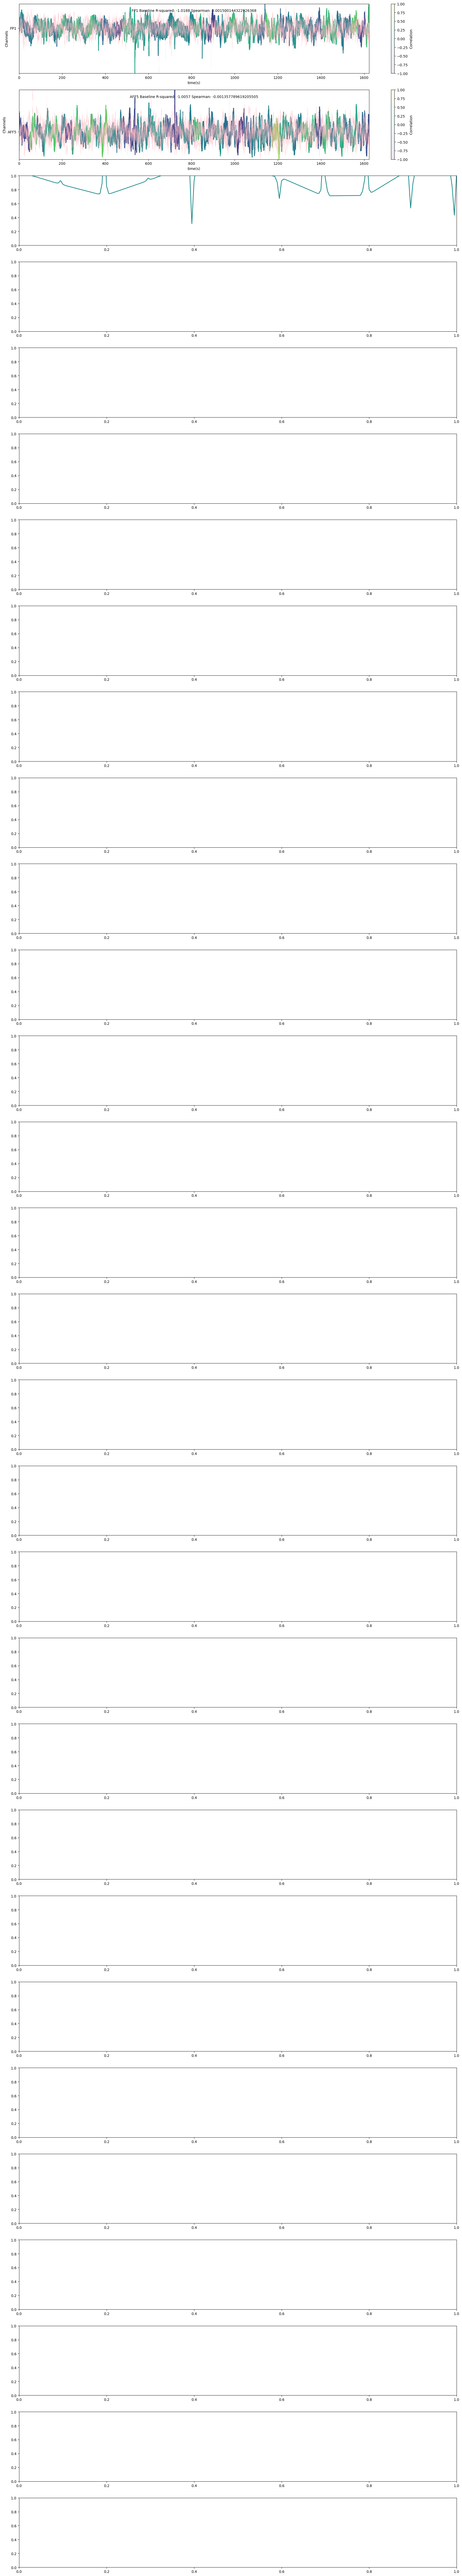

In [12]:
# Define channels to use
nirs_channels_to_use_base = list(NIRS_COORDS.keys())
nirs_channel_index = find_indices(list(NIRS_COORDS.keys()),nirs_channels_to_use_base)

eeg_channels_to_use = EEG_CHANNEL_NAMES
eeg_channel_index = find_indices(EEG_CHANNEL_NAMES,eeg_channels_to_use)

for subject_id_int in subject_ids[1:3]:
    for model_name_base in ['rnn', 'mlp']:
        run_model(subject_id_int, 
                  model_name_base, 
                  nirs_channels_to_use_base, 
                  eeg_channels_to_use, 
                  eeg_channel_index, 
                  nirs_channel_index, 
                  num_epochs, 
                  redo_train=False)
        gc.collect()
        torch.cuda.empty_cache()

## Group

In [ ]:
asdas=adasd
test = [4]
test_subject_id = ''
for i in test:
    test_subject_id += f'{i:02d}'
    
model_name = f'transformer_{test_subject_id}'

# Define channels to use
nirs_channels_to_use_base = list(NIRS_COORDS.keys())[:16]
nirs_channel_index = find_indices(list(NIRS_COORDS.keys()),nirs_channels_to_use_base)

eeg_channels_to_use = EEG_CHANNEL_NAMES
eeg_channel_index = find_indices(EEG_CHANNEL_NAMES,eeg_channels_to_use)

final_model_path = os.path.join(MODEL_WEIGHTS, f'{model_name}_{num_epochs}.pth')
if os.path.exists(final_model_path):
    print(f'Model name exists, skipping {model_name}')
else:
    print(f'Starting {model_name}')
    model = create_mlp(nirs_channels_to_use_base, eeg_channels_to_use, token_size)
        
    # Pre-allocate memory for training and testing data
    eeg_windowed_train = np.empty((0, eeg_lookback, len(eeg_channels_to_use)))
    nirs_windowed_train = np.empty((0, fnirs_lookback, len(nirs_channels_to_use_base)))
    eeg_windowed_test = np.empty((0, eeg_lookback, len(eeg_channels_to_use)))
    nirs_windowed_test = np.empty((0, fnirs_lookback, len(nirs_channels_to_use_base)))
    
    for i in subject_ids:
        subject_id = f'{i:02d}'
    
        subject_data = loadmat(os.path.join(BASE_PATH, 'matfiles', f'data_vp0{subject_id}.mat'))['subject_data_struct'][0]
        # eeg subject_data[1][0]
        eeg_data = []
        for session_eeg_data in subject_data[1][0]:
            eeg_data.append(session_eeg_data.T)
        eeg_data = np.hstack(eeg_data)
        # fnirs subject_data[3][0]
        nirs_data = []
        for session_nirs_data in subject_data[3][0]:
            nirs_data.append(session_nirs_data.T)
        nirs_data = np.hstack(nirs_data)
        # mrk subject_data[5][0]
    
        assert eeg_data.shape[1] == nirs_data.shape[1]
        
        if i not in test and do_train:
            single_eeg_windowed_train, single_nirs_windowed_train, meta_data = grab_random_windows(
                            nirs_data=nirs_data, 
                            eeg_data=eeg_data,
                            sampling_rate=200,
                            nirs_t_min=nirs_t_min, 
                            nirs_t_max=nirs_t_max,
                            eeg_t_min=0, 
                            eeg_t_max=1,
                            number_of_windows=10000)
            
            print(single_eeg_windowed_train.shape) # (1000, 30, 200)
            print(single_nirs_windowed_train.shape) # (1000, 30, 200)
                
            # reduce data
            print(f'Start reducing data')
            if not os.path.exists(CCA_DICT_PATH):
                cca_dict = fit_cca_model(single_eeg_windowed_train, single_nirs_windowed_train, token_size)
                joblib.dump(cca_dict, CCA_DICT_PATH)
            else:
                cca_dict = joblib.load(CCA_DICT_PATH)

            single_nirs_windowed_train = perform_cca_over_channels(single_nirs_windowed_train, cca_dict, token_size)

            print(single_eeg_windowed_train.shape) # (1000, 30, 200)
            print(single_nirs_windowed_train.shape) # (1000, 36, 10)

            n_channels = single_nirs_windowed_train.shape[1]
            # plot channels
            fig, axs = plt.subplots(n_channels, 1, figsize=(10, 10))
            for i in range(n_channels):
                axs[i].plot(single_nirs_windowed_train[0, i, :])
            plt.show()
    
            # Append to the preallocated arrays
            single_eeg_transposed = single_eeg_windowed_train.transpose(0,2,1)
            single_nirs_transposed = single_nirs_windowed_train.transpose(0,2,1)
    
            single_eeg_transposed = single_eeg_transposed[:,:eeg_lookback, eeg_channel_index]
            single_nirs_transposed = single_nirs_transposed[:,:, nirs_channel_index]
    
            # Stack new data into the existing array, avoiding list append
            eeg_windowed_train = np.vstack((eeg_windowed_train, single_eeg_transposed))
            nirs_windowed_train = np.vstack((nirs_windowed_train, single_nirs_transposed))   
        elif i not in test and not do_train:
            
            assert os.path.exists(CCA_DICT_PATH)
            cca_dict = joblib.load(CCA_DICT_PATH)

            single_eeg_windowed_train, single_nirs_windowed_train, meta_data = grab_ordered_windows(
                    nirs_data=nirs_data, 
                    eeg_data=eeg_data,
                    sampling_rate=200,
                    nirs_t_min=nirs_t_min, 
                    nirs_t_max=nirs_t_max,
                    eeg_t_min=0, 
                    eeg_t_max=1)
                
            single_nirs_windowed_train = perform_cca_over_channels(single_nirs_windowed_train, cca_dict, token_size)
            
            single_eeg_windowed_train = single_eeg_windowed_train.transpose(0,2,1)
            single_nirs_windowed_train = single_nirs_windowed_train.transpose(0,2,1)
        
            single_eeg_windowed_train = single_eeg_windowed_train[:,:eeg_lookback, eeg_channel_index]
            single_nirs_windowed_train = single_nirs_windowed_train[:,:, nirs_channel_index]
            
            # For test data, direct stacking since no windowing
            eeg_windowed_train = np.vstack((eeg_windowed_train, single_eeg_windowed_train))
            nirs_windowed_train = np.vstack((nirs_windowed_train, single_nirs_windowed_train))
        else:
            assert os.path.exists(CCA_DICT_PATH)
            cca_dict = joblib.load(CCA_DICT_PATH)

            single_eeg_windowed_test, single_nirs_windowed_test, meta_data = grab_ordered_windows(
                    nirs_data=nirs_data, 
                    eeg_data=eeg_data,
                    sampling_rate=200,
                    nirs_t_min=nirs_t_min, 
                    nirs_t_max=nirs_t_max,
                    eeg_t_min=0, 
                    eeg_t_max=1)
            
            single_eeg_windowed_test = single_eeg_windowed_test.transpose(0,2,1)
            single_nirs_windowed_test = single_nirs_windowed_test.transpose(0,2,1)
            
            single_eeg_windowed_test = single_eeg_windowed_test[:,:eeg_lookback, eeg_channel_index]
            single_nirs_windowed_test = single_nirs_windowed_test[:,:, nirs_channel_index]
            
            # For test data, direct stacking since no windowing
            eeg_windowed_test = np.vstack((eeg_windowed_test, single_eeg_windowed_test))
            nirs_windowed_test = np.vstack((nirs_windowed_test, single_nirs_windowed_test))
            
            print(f'Skipping {subject_id}')

    print(f'EEG Shape: {eeg_windowed_train.shape}')
    print(f'NIRS Shape: {nirs_windowed_train.shape}')
    
    if do_train:
        nirs_train_tensor = torch.from_numpy(nirs_windowed_train).float()
        eeg_train_tensor = torch.from_numpy(eeg_windowed_train).float()
        meta_data_tensor = torch.from_numpy(np.array(meta_data)).float()
        
        print(nirs_train_tensor.shape)
        print(eeg_train_tensor.shape)
        
        sequence_length = eeg_train_tensor.shape[1]
        eeg_number_of_features = eeg_train_tensor.shape[2]
        nirs_number_of_features = nirs_train_tensor.shape[2]
        
        dataset = EEGfNIRSData(nirs_train_tensor, eeg_train_tensor)
        dataloader = DataLoader(dataset, batch_size=500, shuffle=True)
    
        latest_epoch = 0
        loss_list = []
        if do_load:
            model_path = f'{model_name}_epoch_1.pth'
    
            # find the latest model
            for file in os.listdir(MODEL_WEIGHTS):
                if file.startswith(f'{model_name}_epoch_'):
                    epoch = int(file.split('_')[-1].split('.')[0])
                    if epoch > latest_epoch:
                        latest_epoch = epoch
                        model_path = file
            print(f'Using Model Weights: {model_path}')
            model.load_state_dict(torch.load(os.path.join(MODEL_WEIGHTS, model_path)))
            
            # load loss list
            with open(os.path.join(MODEL_WEIGHTS, f'loss_{model_name}_{latest_epoch}.csv'), 'r') as file_ptr:
                reader = csv.reader(file_ptr)
                loss_list = list(reader)[0]
            print(f'Last loss: {float(loss_list[-1])/len(dataloader):.4f}')
    
        model.to(DEVICE)
    
        # Optimizer and loss function
        optimizer = Adam(model.parameters(), lr=0.00001)
        loss_function = torch.nn.MSELoss()
        for epoch in range(latest_epoch, num_epochs):
            model.train()
            total_loss = 0
    
            for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
                X_batch = X_batch.to(DEVICE).float()
                y_batch = y_batch.to(DEVICE).float()
                
                # Forward pass
                predictions = model(X_batch)
    
                # Loss calculation
                loss = loss_function(predictions, y_batch)
    
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    
                total_loss += loss.item()
                # if (batch_idx+1) % 20 == 0 or batch_idx == 0:
                #     print(f'Epoch: {epoch+1}, Batch: {batch_idx+1}, Loss: {loss.item():.4f}')
            
            loss_list.append(total_loss)
        
            if (epoch+1) % 50 == 0:
                # Save model weights
                torch.save(model.state_dict(), os.path.join(MODEL_WEIGHTS, f'{model_name}_{epoch+1}.pth'))
                with open(os.path.join(MODEL_WEIGHTS,f'loss_{model_name}_{epoch+1}.csv'), 'w', newline='') as file_ptr:
                    wr = csv.writer(file_ptr, quoting=csv.QUOTE_ALL)
                    wr.writerow(loss_list)
                
            # Plotting target vs. output for the first example in the last batch
            # single_actual = y_batch[0, :, 0].detach().cpu().numpy()
            # single_predicted = predictions[0,:,0].detach().cpu().numpy()
            # r2 = r2_score(single_actual, single_predicted)
            # print(f'R-squared: {r2}')
            # if (epoch+1) % 10 == 0:
            #     plot_series(single_actual, single_predicted, epoch)
    
            print(f'Epoch: {epoch+1}, Average Loss: {total_loss / len(dataloader):.4f}')
    
    # Perform inference on test
    
    nirs_test_tensor = torch.from_numpy(nirs_windowed_test).float()
    eeg_test_tensor = torch.from_numpy(eeg_windowed_test).float()
    
    # Assuming fnirs_test and eeg_test are your test datasets
    test_dataset = EEGfNIRSData(nirs_test_tensor, eeg_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    # Get weights for specific epoch
    weight_epochs = [50,100]
    for weight_epoch in weight_epochs:
        model_path = f'{model_name}_{weight_epoch}.pth'
        model.load_state_dict(torch.load(os.path.join(MODEL_WEIGHTS, model_path)))
        model.to(DEVICE)
        # Set model to evaluation mode
        model.eval()
        
        # Perform inference on test data
        predictions = []
        targets = []
        for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
            X_batch = X_batch.to(DEVICE).float()
            y_batch = y_batch.to(DEVICE).float()
            predictions.append(model(X_batch).detach().cpu().numpy())
            targets.append(y_batch.detach().cpu().numpy())
        
        predictions = np.array(predictions)
        targets = np.array(targets)
        
        # concatenate and plot
        predictions = predictions.reshape(-1, len(eeg_channels_to_use))
        targets = targets.reshape(-1, len(eeg_channels_to_use))
    
        scipy.io.savemat(os.path.join(OUTPUT_DIRECTORY, f'test_{model_name}_{weight_epoch}.mat'), {'X': targets, 
                                                                'XPred':predictions,
                                                            'bins':10,
                                                            'scale':10,
                                                            'srate':200})
        
        # R2 score
        r2 = r2_score(targets, predictions)
        print(f'Epoch-{weight_epoch}: {r2}')
        
        # Plotting target vs. output on concatenated data
        for i in range(len(eeg_channels_to_use)):
            plt.figure(figsize=(10, 4))
            plt.plot(targets[:,i], label='Target')
            plt.plot(predictions[:,i], label='Output', linestyle='--')
            plt.title(f'Epoch-{weight_epoch} Channel {eeg_channels_to_use[i]} : {r2}')
            plt.legend()
            plt.grid(True)
            plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'test_{model_name}_{weight_epoch}.jpeg'))

    gc.collect()
        


NameError: name 'adasd' is not defined